## Movielens - Content-based exploratory analysis

In [1]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import ndcg_score
from nltk.tokenize import RegexpTokenizer
import re
import string
import random
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
moviesDF = pd.read_csv("ml-latest/movies.csv", sep=",")
moviesDF.movieId = moviesDF.movieId.astype(int)
moviesDF.set_index("movieId", inplace=True)

# Extract years
moviesDF["year"] = moviesDF.title.str.extract(r'\(([0-9]+)\)')
moviesDF["year"] = moviesDF.year.astype("float")

# Extract genres
moviesDF["genres"] = moviesDF.genres.str.split("|")
moviesDF.fillna(0, inplace=True)

moviesDF

,title,genres,year
movieId,,,
1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1995.0
2,Jumanji (1995),"[Adventure, Children, Fantasy]",1995.0
3,Grumpier Old Men (1995),"[Comedy, Romance]",1995.0
4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",1995.0
5,Father of the Bride Part II (1995),[Comedy],1995.0
...,...,...,...
193876,The Great Glinka (1946),[(no genres listed)],1946.0
193878,Les tribulations d'une caissière (2011),[Comedy],2011.0
193880,Her Name Was Mumu (2016),[Drama],2016.0


### Genre Distribution

<AxesSubplot: >

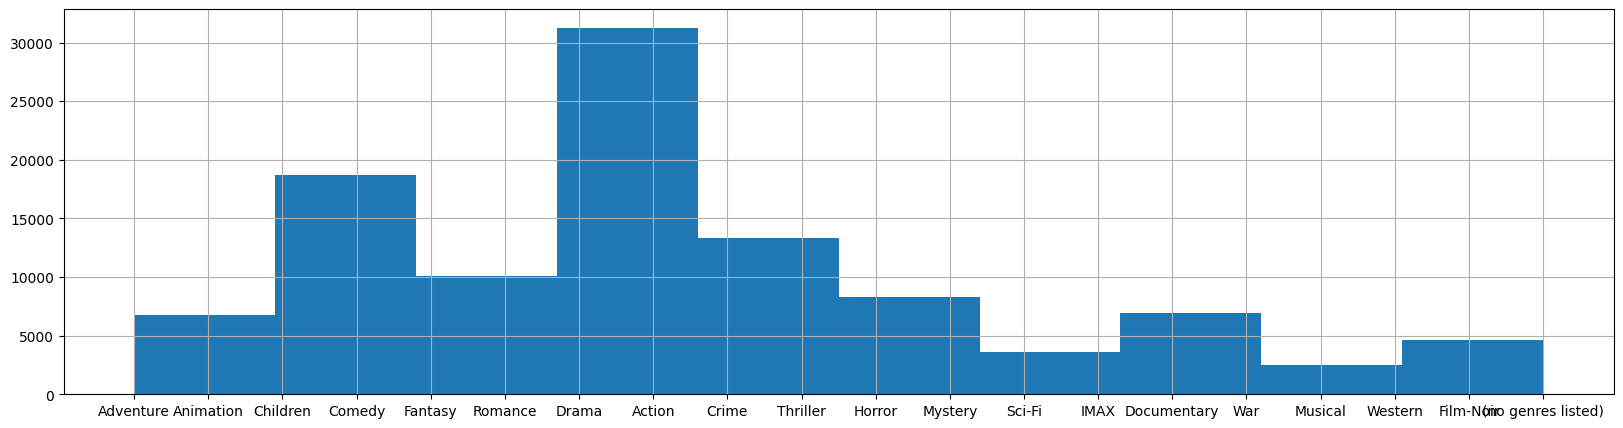

In [3]:
genres = pd.Series(np.concatenate(moviesDF.genres.values))
genres.hist(figsize = (20,5))

In [4]:
genres.unique()

array(['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy',
       'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror',
       'Mystery', 'Sci-Fi', 'IMAX', 'Documentary', 'War', 'Musical',
       'Western', 'Film-Noir', '(no genres listed)'], dtype=object)

### Year Distribution

In [5]:
moviesDF.loc[moviesDF.year <= 1800] # Years don't make sense cause the first film ever made was in 1888

,title,genres,year
movieId,,,
889,1-900 (06) (1994),"[Drama, Romance]",6.0
32930,Category 6: Day of Destruction,"[Action, Drama]",0.0
40697,Babylon 5,[Sci-Fi],0.0
69757,(500) Days of Summer (2009),"[Comedy, Drama, Romance]",500.0
79607,"Millions Game, The (Das Millionenspiel)","[Action, Drama, Sci-Fi, Thriller]",0.0
...,...,...,...
192339,The Sign of Three,[(no genres listed)],0.0
192829,Parwaaz Hai Junoon,"[Adventure, Children, Romance]",0.0
193149,¿Qué te juegas?,[(no genres listed)],0.0


<AxesSubplot: >

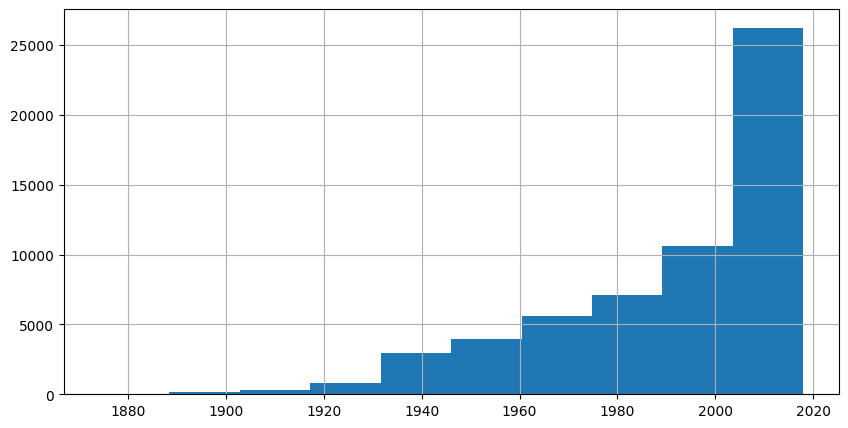

In [6]:
moviesDF.loc[moviesDF.year >= 1800].year.hist(figsize=(10,5)) # most of the movies are novel

### (User-made) Tags Distribution

In [7]:
tagsDF = pd.read_csv("ml-latest/tags.csv", sep=",")
tagsDF

,userId,movieId,tag,timestamp
0,14,110,epic,1443148538
1,14,110,Medieval,1443148532
2,14,260,sci-fi,1442169410
3,14,260,space action,1442169421
4,14,318,imdb top 250,1442615195
...,...,...,...,...
1108992,283206,73017,fun,1264379059
1108993,283206,73017,homoerotic subtext,1264379058
1108994,283206,73017,pacing,1264379058
1108995,283206,73017,plot,1264379058


Tags are written by users as plain-text/description, so we should use TF-IDF for VSM model for vectorization.

In [8]:
tagsDF.tag.unique().shape # unique Tag count

(74715,)

In [9]:
tagsDF.tag.apply(type).unique() # Tags contain different types of values (or NaN)

array([<class 'str'>, <class 'float'>], dtype=object)

### Content-based Vector Space Model Recommender - Evaluation

In [10]:
moviesDF.genres = moviesDF.genres.apply(lambda x: list(map(lambda g: g.lower(), x)))
moviesDF['titleCleaned'] = moviesDF.title.str.replace(r'\(([0-9]+)\)$', "").str.strip()

In [11]:
def get_title_similarity(data):
    # Converting the movie title into vectors and used bigram
    tf = TfidfVectorizer(analyzer='word', ngram_range=(2, 2), min_df = 1, stop_words='english')
    tfidf_matrix = tf.fit_transform(data['titleCleaned'])
    
    # Calculating the similarity measures based on Cosine Similarity
    sg = cosine_similarity(tfidf_matrix, tfidf_matrix)
    return sg

In [12]:
STOPS = set(stopwords.words("english"))

# Function for removing NonAscii characters
def remove_non_ascii(s):
    return "".join([i for i in str(s) if ord(i)<128])

# Function for converting into lower case
def get_lower_case(text):
    return str(text).lower()

# Function for removing stop words
def remove_stop_words(text):
    text = str(text).split()
    text = " ".join([w for w in text if not w in STOPS])
    return text

# Function for removing punctuation
def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = " ".join(tokenizer.tokenize(str(text)))
    return text

In [13]:
# Applying all the preprocessing functions and storing as cleaned tags
tagsDF['tagCleaned'] = tagsDF.tag.apply(remove_non_ascii)
tagsDF['tagCleaned'] = tagsDF.tagCleaned.apply(get_lower_case)
tagsDF['tagCleaned'] = tagsDF.tagCleaned.apply(remove_stop_words)
tagsDF['tagCleaned'] = tagsDF.tagCleaned.apply(remove_punctuation)

In [14]:
tags = []
for ind in moviesDF.index:
    tags.append(" ".join(tagsDF.tagCleaned.loc[tagsDF.movieId == ind]))
moviesDF["tags"] = tags
moviesDF

,title,genres,year,titleCleaned,tags
movieId,,,,,
1,Toy Story (1995),"[adventure, animation, children, comedy, fantasy]",1995.0,Toy Story,animated buddy movie cartoon cgi comedy comput...
2,Jumanji (1995),"[adventure, children, fantasy]",1995.0,Jumanji,fantasy adapted from book animals bad cgi base...
3,Grumpier Old Men (1995),"[comedy, romance]",1995.0,Grumpier Old Men,moldy old ann margaret burgess meredith daryl ...
4,Waiting to Exhale (1995),"[comedy, drama, romance]",1995.0,Waiting to Exhale,characters girl movie characters chick flick b...
5,Father of the Bride Part II (1995),[comedy],1995.0,Father of the Bride Part II,steve martin steve martin pregnancy remake agi...
...,...,...,...,...,...
193876,The Great Glinka (1946),[(no genres listed)],1946.0,The Great Glinka,
193878,Les tribulations d'une caissière (2011),[comedy],2011.0,Les tribulations d'une caissière,
193880,Her Name Was Mumu (2016),[drama],2016.0,Her Name Was Mumu,


In [45]:
def get_tag_similarity(data: pd.DataFrame):
    # In this particular case, it's better to use TF-IDF as well with 1-gram setting
    
    # count = CountVectorizer(stop_words='english')
    # count_matrix = count.fit_transform(data['tags'].str.replace(" ", ""))
    # sg = cosine_similarity(count_matrix, count_matrix)
    
    # Converting movie tags into vectors
    tf = TfidfVectorizer(analyzer='word', min_df = 1, stop_words='english')
    tfidf_matrix = tf.fit_transform(data['tags'])
    
    # Calculating the similarity measures based on Cosine Similarity
    sg = cosine_similarity(tfidf_matrix, tfidf_matrix)
    return sg

In [65]:
def recommend(titles: list, genres : list = None, yearMin = 1800, yearMax = 3000, useTitleSim = False, top_k=10):
    def check_genre(genre_list: list):
        for g in genre_list:
            if g in genres:
                return True
        return False
    
    # Matching the genre with the dataset and reset the index
    data = moviesDF.loc[moviesDF.year >= yearMin]
    data = data.loc[data.year <= yearMax]
    if genres != None:
        data = data.loc[data.genres.apply(check_genre)]
    data.reset_index(level = 0, inplace = True)

    # Convert the index into series
    indices = pd.Series(data.index, index = data['titleCleaned'])
    
    title_sim = get_title_similarity(data) if useTitleSim else None
    tag_sim = get_tag_similarity(data)
        
    sim_total = None
    for title in titles:
        # Get the index corresponding to original_title
        idx = indices[title] # Get the pairwsie similarity scores
        
        sim = list(enumerate(title_sim[idx] + tag_sim[idx])) if useTitleSim \
            else list(enumerate(tag_sim[idx])) # Sort the movies
        
        sim_total = sim if sim_total is None else sim_total + sim
    
    sim_total = sorted(sim_total, key=lambda x: x[1], reverse=True) # Scores of the top_k most similar movies
    sim_total = sim_total[1:top_k+1] # Movie indicies
    movie_indices = [i[0] for i in sim_total]
    
    # Top 20 movie recommendation
    rec = data.loc[movie_indices]
    rec["similarityScore"] = [i[1] for i in sim_total]
    
    return rec

In [77]:
recommend(["Interstellar"], ["sci-fi"], useTitleSim=False)

,movieId,title,genres,year,titleCleaned,tags,similarityScore
1883,130440,The Time Guardian (1987),[sci-fi],1987.0,The Time Guardian,space time travel,0.496115
2480,157563,Indru Netru Naalai (2015),"[comedy, sci-fi]",2015.0,Indru Netru Naalai,time travel,0.414571
2777,170283,The Time Shifters (1999),"[action, sci-fi, thriller]",1999.0,The Time Shifters,time travel,0.414571
2795,170733,24 (2016),"[action, sci-fi, thriller]",2016.0,24,time travel,0.414571
3187,184097,Curvature (2017),"[drama, sci-fi]",2017.0,Curvature,time travel,0.414571
1996,135859,Rewind (2013),[sci-fi],2013.0,Rewind,time travel time travel made tv time travel ti...,0.407000
2479,157387,Paradox (2016),"[action, sci-fi]",2016.0,Paradox,bad acting bad plot time travel time travel ti...,0.401852
118,2011,Back to the Future Part II (1989),"[adventure, comedy, sci-fi]",1989.0,Back to the Future Part II,time loop alternate universe logic complexity ...,0.401403
119,2012,Back to the Future Part III (1990),"[adventure, comedy, sci-fi, western]",1990.0,Back to the Future Part III,time travel alternate universe sequels filmed ...,0.389947
3232,186205,Altered Hours (2016),"[sci-fi, thriller]",2016.0,Altered Hours,sci fi thriller time travel,0.376084


In [75]:
recommend(["Interstellar"], ["sci-fi"], useTitleSim=True)

,movieId,title,genres,year,titleCleaned,tags,similarityScore
1883,130440,The Time Guardian (1987),[sci-fi],1987.0,The Time Guardian,space time travel,0.496115
2480,157563,Indru Netru Naalai (2015),"[comedy, sci-fi]",2015.0,Indru Netru Naalai,time travel,0.414571
2777,170283,The Time Shifters (1999),"[action, sci-fi, thriller]",1999.0,The Time Shifters,time travel,0.414571
2795,170733,24 (2016),"[action, sci-fi, thriller]",2016.0,24,time travel,0.414571
3187,184097,Curvature (2017),"[drama, sci-fi]",2017.0,Curvature,time travel,0.414571
1996,135859,Rewind (2013),[sci-fi],2013.0,Rewind,time travel time travel made tv time travel ti...,0.407000
2479,157387,Paradox (2016),"[action, sci-fi]",2016.0,Paradox,bad acting bad plot time travel time travel ti...,0.401852
118,2011,Back to the Future Part II (1989),"[adventure, comedy, sci-fi]",1989.0,Back to the Future Part II,time loop alternate universe logic complexity ...,0.401403
119,2012,Back to the Future Part III (1990),"[adventure, comedy, sci-fi, western]",1990.0,Back to the Future Part III,time travel alternate universe sequels filmed ...,0.389947
3232,186205,Altered Hours (2016),"[sci-fi, thriller]",2016.0,Altered Hours,sci fi thriller time travel,0.376084


In [68]:
recommend(["Harry Potter and the Chamber of Secrets"], ["fantasy"], useTitleSim=True)

,movieId,title,genres,year,titleCleaned,tags,similarityScore
240,4896,Harry Potter and the Sorcerer's Stone (a.k.a. ...,"[adventure, children, fantasy]",2001.0,Harry Potter and the Sorcerer's Stone (a.k.a. ...,school drama based book based book children ch...,1.147204
548,40815,Harry Potter and the Goblet of Fire (2005),"[adventure, fantasy, thriller, imax]",2005.0,Harry Potter and the Goblet of Fire,plot holes harry potter magic kids adventure d...,1.118758
653,54001,Harry Potter and the Order of the Phoenix (2007),"[adventure, drama, fantasy, imax]",2007.0,Harry Potter and the Order of the Phoenix,alan rickman emma watson harry potter based bo...,1.076109
375,8368,Harry Potter and the Prisoner of Azkaban (2004),"[adventure, fantasy, imax]",2004.0,Harry Potter and the Prisoner of Azkaban,harry potter magic time travel wizards time tr...,1.052537
763,69844,Harry Potter and the Half-Blood Prince (2009),"[adventure, fantasy, mystery, romance, imax]",2009.0,Harry Potter and the Half-Blood Prince,magic disappointing franchise magic alan rickm...,0.994992
893,81834,Harry Potter and the Deathly Hallows: Part 1 (...,"[action, adventure, fantasy, imax]",2010.0,Harry Potter and the Deathly Hallows: Part 1,british england helena bonham carter london da...,0.953786
961,88125,Harry Potter and the Deathly Hallows: Part 2 (...,"[action, adventure, drama, fantasy, mystery, i...",2011.0,Harry Potter and the Deathly Hallows: Part 2,great cinematography author j k rowling based ...,0.902513
2571,190165,Severus Snape and the Marauders (2016),"[adventure, drama, fantasy, mystery]",2016.0,Severus Snape and the Marauders,based book dual fan film fantasy harry potter ...,0.432235
1569,135143,Fantastic Beasts and Where to Find Them (2016),[fantasy],2016.0,Fantastic Beasts and Where to Find Them,1920 s 1920s bigger inside colin farrell eddie...,0.383844
773,70802,"Secret of Moonacre, The (2008)","[adventure, fantasy, romance]",2008.0,"Secret of Moonacre, The",based book fantasy,0.381247


If we do only title-based content filtering we get quite obvious Over-specialization with Title bias.

In [69]:
recommend(["Harry Potter and the Chamber of Secrets"], ["fantasy"], useTitleSim=False)

,movieId,title,genres,year,titleCleaned,tags,similarityScore
240,4896,Harry Potter and the Sorcerer's Stone (a.k.a. ...,"[adventure, children, fantasy]",2001.0,Harry Potter and the Sorcerer's Stone (a.k.a. ...,school drama based book based book children ch...,0.859006
653,54001,Harry Potter and the Order of the Phoenix (2007),"[adventure, drama, fantasy, imax]",2007.0,Harry Potter and the Order of the Phoenix,alan rickman emma watson harry potter based bo...,0.832163
548,40815,Harry Potter and the Goblet of Fire (2005),"[adventure, fantasy, thriller, imax]",2005.0,Harry Potter and the Goblet of Fire,plot holes harry potter magic kids adventure d...,0.809439
375,8368,Harry Potter and the Prisoner of Azkaban (2004),"[adventure, fantasy, imax]",2004.0,Harry Potter and the Prisoner of Azkaban,harry potter magic time travel wizards time tr...,0.808592
763,69844,Harry Potter and the Half-Blood Prince (2009),"[adventure, fantasy, mystery, romance, imax]",2009.0,Harry Potter and the Half-Blood Prince,magic disappointing franchise magic alan rickm...,0.787184
893,81834,Harry Potter and the Deathly Hallows: Part 1 (...,"[action, adventure, fantasy, imax]",2010.0,Harry Potter and the Deathly Hallows: Part 1,british england helena bonham carter london da...,0.700408
961,88125,Harry Potter and the Deathly Hallows: Part 2 (...,"[action, adventure, drama, fantasy, mystery, i...",2011.0,Harry Potter and the Deathly Hallows: Part 2,great cinematography author j k rowling based ...,0.649135
2571,190165,Severus Snape and the Marauders (2016),"[adventure, drama, fantasy, mystery]",2016.0,Severus Snape and the Marauders,based book dual fan film fantasy harry potter ...,0.432235
1569,135143,Fantastic Beasts and Where to Find Them (2016),[fantasy],2016.0,Fantastic Beasts and Where to Find Them,1920 s 1920s bigger inside colin farrell eddie...,0.383844
773,70802,"Secret of Moonacre, The (2008)","[adventure, fantasy, romance]",2008.0,"Secret of Moonacre, The",based book fantasy,0.381247


## Practical application given User Data

In [70]:
myRatings = {
    "userId":[611,611,611,611,611,611,611,611,611,611],
    "movieId":[109487,164909,79132,4310,41571,109374,6874,180263,318,3785],
    "rating":[5.0,4.0,4.5,4.5,5.0,4.0,1.0,1.0,5.0,1.0],
    "timestamp":[0,0,0,0,0,0,0,0,0,0]
            }
myRatings = pd.DataFrame(myRatings)

In [71]:
fav_movie_id = myRatings.loc[myRatings.rating == myRatings.rating.max()].movieId.values
fav_movie_names = moviesDF.titleCleaned[fav_movie_id]
fav_movie_names = pd.DataFrame(fav_movie_names, index=fav_movie_names.index)
fav_movie_names["genres"] = moviesDF.genres[fav_movie_id]
fav_movie_names

,titleCleaned,genres
movieId,,
109487,Interstellar,"[sci-fi, imax]"
41571,Memoirs of a Geisha,"[drama, romance]"
318,"Shawshank Redemption, The","[crime, drama]"


In [80]:
# Slow implementation of Hybrid approach (causes memory leak)
# recommend(["Memoirs of a Geisha", "Shawshank Redemption, The"], ["scifi", "drama"])

,movieId,title,genres,year,titleCleaned,tags,similarityScore
171,318,"Shawshank Redemption, The (1994)","[crime, drama]",1994.0,"Shawshank Redemption, The",imdb top 250 justice story line hope inspirati...,1.000000
18902,159712,Tales of a Golden Geisha (1990),"[comedy, drama]",1990.0,Tales of a Golden Geisha,geisha japanese,0.613226
22059,180051,The Geisha (1983),"[drama, romance, war]",1983.0,The Geisha,geisha,0.529010
10644,99933,"Year of the Tiger, The (Año del tigre, El) (2011)",[drama],2011.0,"Year of the Tiger, The (Año del tigre, El)",escape prison prison,0.500072
6479,58130,Up the River (1930),"[comedy, crime, drama]",1930.0,Up the River,escape prison,0.472809
13423,121807,The Getaway (1941),"[crime, drama, mystery, romance]",1941.0,The Getaway,escape prison,0.472809
18310,155469,Jailbreak (1936),[drama],1936.0,Jailbreak,escape prison,0.472809
15232,134210,Shinsengumi: Assassins of Honor (1970),"[action, drama]",1970.0,Shinsengumi: Assassins of Honor,history independent film japan japanese cultur...,0.470448
14922,132216,The Last Mile (1959),"[crime, drama, thriller]",1959.0,The Last Mile,prison,0.434151
15621,137250,It’s Only Make Believe (2013),[drama],2013.0,It’s Only Make Believe,prison,0.434151


Given the use of title + tag based recommendation we get more interesting similaryScores.

In [ ]:
recommend(["Memoirs of a Geisha"], ["drama", "romance"], useTitleSim=False)

,movieId,title,genres,year,titleCleaned,tags,similarityScore
21154,159712,Tales of a Golden Geisha (1990),"[comedy, drama]",1990.0,Tales of a Golden Geisha,geisha japanese,0.614800
24698,180051,The Geisha (1983),"[drama, romance, war]",1983.0,The Geisha,geisha,0.530751
17066,134210,Shinsengumi: Assassins of Honor (1970),"[action, drama]",1970.0,Shinsengumi: Assassins of Honor,history independent film japan japanese cultur...,0.470650
6784,51060,Sisters of the Gion (Gion no shimai) (1936),[drama],1936.0,Sisters of the Gion (Gion no shimai),geisha japan kyoto japan lover criterion kenji...,0.407046
19501,149784,Closed Note (2007),[romance],2007.0,Closed Note,romance japan,0.406071
14687,120100,First Yank Into Tokyo (1945),"[drama, war]",1945.0,First Yank Into Tokyo,japan,0.400632
18389,142564,A Stranger of Mine (2005),"[comedy, crime, drama, horror]",2005.0,A Stranger of Mine,japan,0.400632
19485,149706,Manhunt (1976),"[action, crime, drama]",1976.0,Manhunt,japan,0.400632
21989,164643,A Bride for Rip Van Winkle (2016),[drama],2016.0,A Bride for Rip Van Winkle,japan,0.400632
19662,150678,Princess Sakura: Forbidden Pleasures (2013),[romance],2013.0,Princess Sakura: Forbidden Pleasures,japanese japanese culture,0.386949


A specific problem with using tile+tag based recommendation (on this dataset) is that most of the time the Title itself is also included in the Tags, such as:
- Tales of a Golden Geisha (1990), tags: geisha japanese, etc.
- Harry Potter and the Order of the Phoenix, tags: alan rickman emma watson harry potter...

Problem could be solved using trigrams or more words for TF-IDF or using tag-only approach, cause the Title is not relevant in these cases.

### Summary

Content-based filtering on MovieLens dataset includes using features such:
- simple filtering: genre, year
- VSM: title, tag, title + tags
- filtering based on novelty and similar time periods

The complete dataset also includes "genome-scores.csv" and "genome-tags.csv" to identify relevance of tags given by users to specific movies:
- "tag"-only filtering could be improved by adding such scores to them